In [241]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from collections import Counter


# Data Preprocessing

There are two data files. '44_million_votes.txt' contains the submission of id of the thread being voted, the subreddit at which the thread locates, the time of vote, the username and epoch time of voting. 'submission_info.txt' contains the sbumission id of the thread, the title of the thread, the subreddit of the thread and the username. 


In [2]:
votes = pd.read_table('44_million_votes.txt')
info = pd.read_table('submission_info.txt')

votes_dated = votes[np.isnan(votes['CREATED_TIME']) == False]
votes_dated['Time'] = pd.to_datetime(votes_dated['CREATED_TIME'],unit='s')
votes_timed = votes_dated.drop(columns=['CREATED_TIME'])
votes_timed.to_csv('votes_timed.csv')

# Percentage of upvotes

In [242]:
votes_timed = pd.read_csv('votes_timed.csv')

upvotes = votes_timed[votes_timed['VOTE'] == 'upvote']
downvotes = votes_timed[votes_timed['VOTE'] == 'downvote']

In [244]:
total_votes = votes_timed.shape[0]
print('% of upvotes:',upvotes.shape[0]/votes_timed.shape[0]*100, '%')
print('% of downvotes:', downvotes.shape[0]/votes_timed.shape[0]*100, '%')

% of upvotes: 76.80760946856265 %
% of downvotes: 23.19239053143736 %


# Hourly change in votes

In [55]:
upvote_hr_counter = Counter(time.hour for time in upvotes['Time'])
downvote_hr_counter = Counter(time.hour for time in downvotes['Time'])

hr_lst = np.linspace(0,23,24)
upvote_hr = []
downvote_hr = []

for hr in hr_lst:
    upvote_hr.append(upvote_hr_counter[hr])
    downvote_hr.append(downvote_hr_counter[hr])

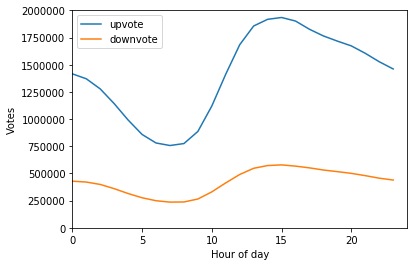

In [246]:
plt.plot(hr_lst,upvote_hr,label='upvote')
plt.plot(hr_lst,downvote_hr,label='downvote')

plt.legend()
plt.xlabel('Hour of day')
plt.ylabel('Votes')
plt.xlim([0,24])
plt.ylim([0,2e6])
plt.show()

I can see that the peak hour for getting votes (both upvotes and downvotes) is in the afternoon. This shows that timing may be an important factor of getting votes (both upvotes and downvotes).